PPG to Respiratory rate

2345
2345


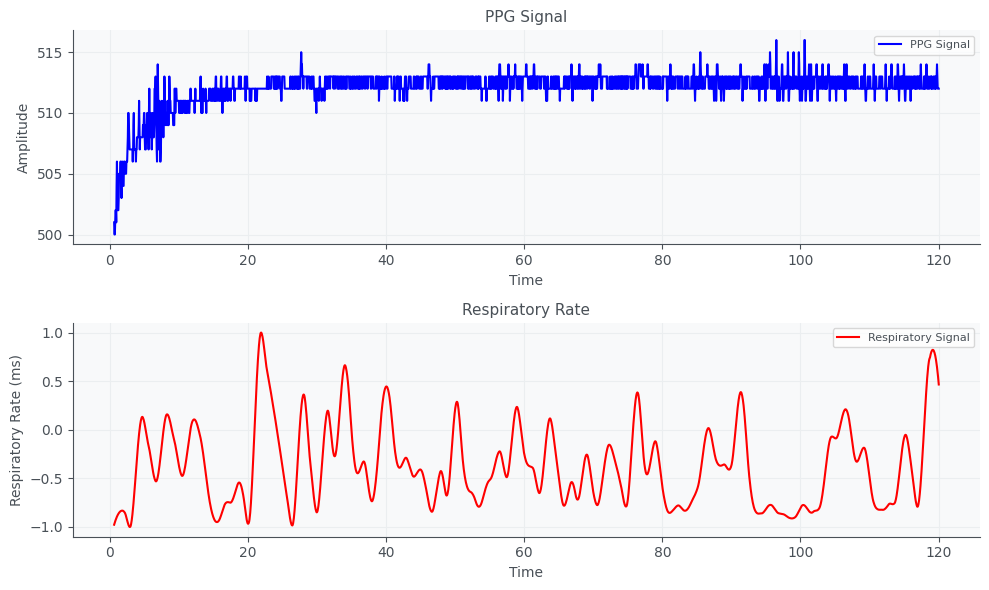

Respiratory rate (BPM): 55.48295559749433


In [94]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sklearn.preprocessing as skp


# Load PPG data from CSV
ppg_data = pd.read_csv('ppg_datamuhammadmoizgohar_gmail_com.csv')

# Assuming your CSV has two columns: 'time' and 'signal'
time = ppg_data['timestamp'].values
ppg_signal = ppg_data['ppg_value'].values

# Define a function to convert PPG signal to respiratory signal
def ppg_to_respiratory(ppg_signal, time, fs=100):
    # Resample PPG signal to a higher frequency for better peak detection accuracy
    resampled_ppg_signal = signal.resample(ppg_signal, len(ppg_signal) * 10)
    resampled_time = np.linspace(time[0], time[-1], len(resampled_ppg_signal))

    # Bandpass filter to remove noise and baseline drift
    b, a = signal.butter(2, [0.5 / (fs / 2), 2 / (fs / 2)], btype='bandpass')
    filtered_ppg_signal = signal.filtfilt(b, a, resampled_ppg_signal)

    # Peak detection in the filtered PPG signal
    peaks, _ = signal.find_peaks(filtered_ppg_signal, distance=fs * 1.5, height=0.2)

    # Calculate time intervals between peaks
    peak_times = resampled_time[peaks]
    peak_intervals = np.diff(peak_times)

    # Remove outliers in peak intervals
    # peak_intervals = remove_outliers(peak_intervals)


    # Calculate respiratory rate (RR) in beats per minute (BPM)
    mean_peak_interval = np.mean(peak_intervals)
    respiratory_rate = 60.0 / mean_peak_interval

    # Interpolate respiratory signal
    respiratory_signal = np.interp(time, peak_times[:-1], peak_intervals)
    smoothed_respiratory_signal = savgol_filter(respiratory_signal, window_length=51, polyorder=2)
    return smoothed_respiratory_signal, respiratory_rate

# Function to remove outliers using median absolute deviation (MAD)
def remove_outliers(data, threshold=5):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    outliers = np.abs(modified_z_scores) > threshold
    return data[~outliers]

# Convert PPG signal to respiratory signal
respiratory_signal, respiratory_rate = ppg_to_respiratory(ppg_signal, time)

# Ensure the lengths of time and respiratory signal match
if len(time) == len(respiratory_signal):
    print(len(time))
    print(len(respiratory_signal))
    # Save respiratory data to a CSV file
    respiratory_data = pd.DataFrame({'time': time, 'respiratory_signal': respiratory_signal})
    # respiratory_data.to_csv('respiratory_signal.csv', index=False)


    # Plot both PPG and respiratory rate
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, ppg_signal, color='b', label='PPG Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('PPG Signal')
    plt.legend()


    plt.subplot(2, 1, 2)
    plt.plot(time,skp.minmax_scale(respiratory_signal, feature_range=(-1, 1)), color='r', label='Respiratory Signal')
    plt.xlabel('Time')
    plt.ylabel('Respiratory Rate (ms)')
    plt.title('Respiratory Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Respiratory rate (BPM):", respiratory_rate)
else:
    print("Length mismatch between time and respiratory signal. Cannot plot.")


PPG to ECG but old method can only work for 512 length segments

Model loaded successfully


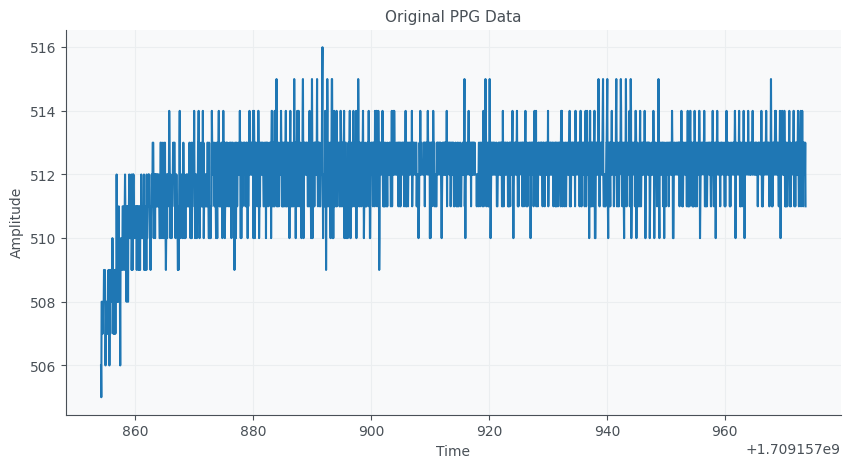

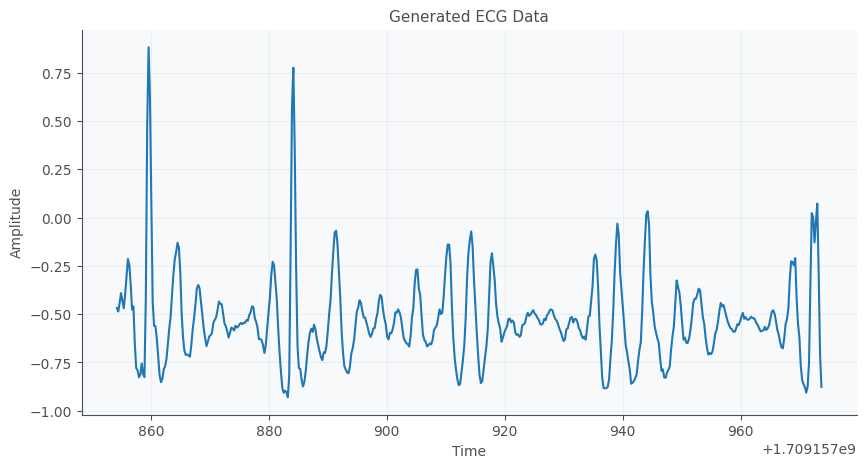

512


In [23]:
import os
import numpy as np
import tensorflow as tf
import cv2
import sklearn.preprocessing as skp
import pandas as pd

import module
import preprocessing
import tflib

tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

@tf.function
def sample_P2E(P, model):
    fake_ecg = model(P, training=False)
    return fake_ecg

########### params ###########
ecg_sampling_freq = 128
ppg_sampling_freq = 128
window_size = 4
ecg_segment_size = ecg_sampling_freq * window_size
ppg_segment_size = ppg_sampling_freq * window_size

model_dir = 'weights'

""" model """
Gen_PPG2ECG = module.generator_attention()
""" restore """
tflib.Checkpoint(dict(Gen_PPG2ECG=Gen_PPG2ECG), model_dir).restore()
print("Model loaded successfully")



# Calculate the number of points in the resampled signal
n_points = int(len(ppg_signal) * ppg_segment_size / len(ppg_signal))

# Create a new time array for the resampled signal
time_resampled = np.linspace(time[0], time[-1], n_points)

# Resample the PPG signal using numpy.interp
x_ppg_resampled = np.interp(time_resampled, time, ppg_signal)

# Filter the data
x_ppg_filtered = preprocessing.filter_ppg(x_ppg_resampled, 128)

# Reshape to Nx512
x_ppg_reshaped = x_ppg_filtered.reshape(1, -1)

# Normalize the data between -1 to 1
x_ppg_normalized = skp.minmax_scale(x_ppg_reshaped, feature_range=(-1, 1), axis=1)

# Convert PPG to ECG
x_ecg = sample_P2E(x_ppg_normalized, Gen_PPG2ECG)

# Convert the tensor to a NumPy array and flatten it
x_ecg = x_ecg.numpy().flatten()



# Plot the original PPG data
plt.figure(figsize=(10, 5))
plt.plot(time, ppg_signal)
plt.title('Original PPG Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot the generated ECG data
plt.figure(figsize=(10, 5))
plt.plot(time_resampled, x_ecg)
plt.title('Generated ECG Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

print(len(time_resampled))

PPG to ECG by making multiple segments

c:\Users\muham\OneDrive\Desktop\Portfolio\Websites\AFIB extractor\venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\muham\OneDrive\Desktop\Portfolio\Websites\AFIB extractor\venv\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things 


Model loaded successfully


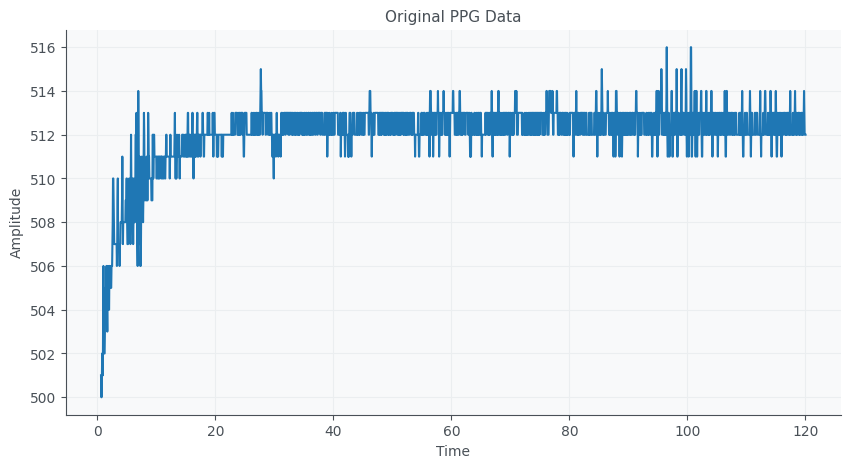

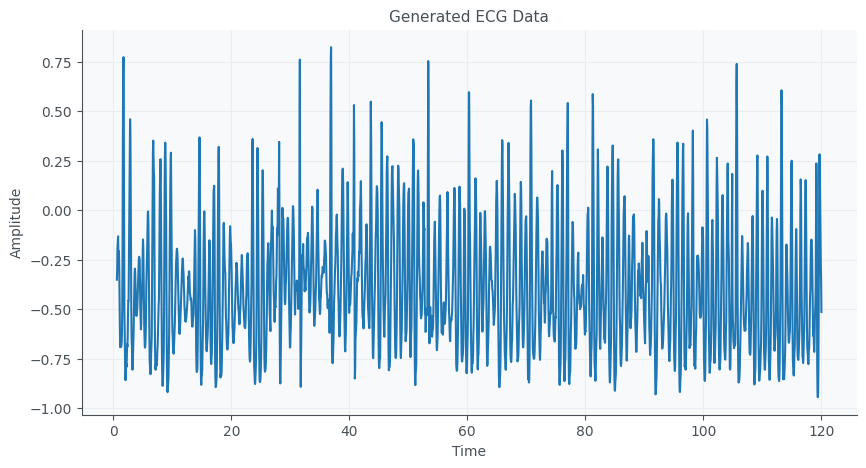

2345


In [19]:
import os
import numpy as np
import tensorflow as tf
import cv2
import sklearn.preprocessing as skp
import pandas as pd
import matplotlib.pyplot as plt  # Add matplotlib import for plotting

import module
import preprocessing
import tflib

tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

@tf.function
def sample_P2E(P, model):
    fake_ecg = model(P, training=False)
    return fake_ecg

########### params ###########
ecg_sampling_freq = 128
ppg_sampling_freq = 128
window_size = 4
ecg_segment_size = ecg_sampling_freq * window_size
ppg_segment_size = ppg_sampling_freq * window_size

model_dir = 'weights'

""" model """
Gen_PPG2ECG = module.generator_attention()
""" restore """
tflib.Checkpoint(dict(Gen_PPG2ECG=Gen_PPG2ECG), model_dir).restore()
print("Model loaded successfully")


num_segments = len(ppg_signal) // 512
x_ppg_segments = np.array_split(ppg_signal, num_segments)

x_ecg_segments = []
num_complete_segments = len(ppg_signal) // 512
remaining_data_points = len(ppg_signal) % 512

for i in range(num_complete_segments):
    segment = ppg_signal[i * 512: (i + 1) * 512]
    
    n_points = len(segment)
    time_resampled = np.linspace(time[i * 512], time[(i + 1) * 512 - 1], n_points)
    segment_resampled = np.interp(time_resampled, time[i * 512: (i + 1) * 512], segment)
    segment_filtered = preprocessing.filter_ppg(segment_resampled, 128)
    segment_reshaped = segment_filtered.reshape(1, -1)
    segment_normalized = skp.minmax_scale(segment_reshaped, feature_range=(-1, 1), axis=1)
    ecg_segment = sample_P2E(segment_normalized, Gen_PPG2ECG)
    ecg_segment = ecg_segment.numpy().flatten()
    x_ecg_segments.append(ecg_segment)

if remaining_data_points > 0:
    last_segment = ppg_signal[-remaining_data_points:]
    n_points = len(last_segment)
    time_resampled = np.linspace(time[-remaining_data_points], time[-1], n_points)
    last_segment_resampled = np.interp(time_resampled, time[-remaining_data_points:], last_segment)
    last_segment_filtered = preprocessing.filter_ppg(last_segment_resampled, 128)
    last_segment_padded = np.pad(last_segment_filtered, (0, 512 - remaining_data_points), mode='constant')
    last_segment_reshaped = last_segment_padded.reshape(1, -1)
    last_segment_normalized = skp.minmax_scale(last_segment_reshaped, feature_range=(-1, 1), axis=1)
    last_ecg_segment = sample_P2E(last_segment_normalized, Gen_PPG2ECG)
    last_ecg_segment = last_ecg_segment.numpy().flatten()
    x_ecg_segments.append(last_ecg_segment)

x_ecg = np.concatenate(x_ecg_segments)
x_ecg = x_ecg[:len(time)]

# Plot the original PPG data
plt.figure(figsize=(10, 5))
plt.plot(time, ppg_signal)
plt.title('Original PPG Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot the generated ECG data using the same time array
plt.figure(figsize=(10, 5))
plt.plot(time, x_ecg)
plt.title('Generated ECG Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

print(len(time))


In [35]:
# pd.read_csv('combined.csv').describe()

,timestamp,ppg_signal,ecg_signal,respiratory_signal
count,2.345000e+03,2345.000000,2345.000000,2345.000000
mean,1.709158e+09,512.019616,-0.479217,1.176165
std,3.449552e+01,1.244630,0.282517,0.279368
min,1.709158e+09,505.000000,-0.954633,0.763969
25%,1.709158e+09,511.000000,-0.680492,0.916508
50%,1.709158e+09,512.000000,-0.529760,1.167371
75%,1.709158e+09,513.000000,-0.338264,1.422139
max,1.709158e+09,516.000000,0.818608,1.958910
